# SLMS

## Required Packages

In [ ]:
# !pip install -Uqqq pip --progress-bar off
# !pip install -qqq torch==2.1 --progress-bar off
# !pip install -qqq accelerate==0.23.0 --progress-bar off
# !pip install -qqq bitsandbytes==0.41.1 --progress-bar off
# !pip install langchain langchain_community
# !pip install langchainhub
# !pip install git+https://github.com/huggingface/transformers
# !wget https://www.plus2net.com/python/download/my_db.db

## Required Libraries

In [ ]:
from langchain import hub
from langchain_community.utilities import SQLDatabase

import sqlite3

import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    GenerationConfig,
    TextStreamer,
    pipeline,
)

from langchain import HuggingFacePipeline
from langchain import PromptTemplate, LLMChain




## SLM Model

In [ ]:
MODEL_NAME = "defog/sqlcoder-7b-2"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME) # ,use_fast=False
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
        trust_remote_code=True,
        # torch_dtype=torch.float16,
         load_in_8bit=True,
        device_map="auto",
        use_cache=True,
)

generation_config = GenerationConfig.from_pretrained(MODEL_NAME)
generation_config.max_new_tokens = 400
generation_config.temperature = 0.0001
generation_config.num_beams=1
generation_config.num_beam_groups=1
generation_config.do_sample = False


llm_pipeline = pipeline(
"text-generation",
model=model,
tokenizer=tokenizer,
return_full_text=True,
generation_config=generation_config,
num_return_sequences=1,
eos_token_id=tokenizer.eos_token_id,
pad_token_id=tokenizer.eos_token_id
)

llm = HuggingFacePipeline(pipeline=llm_pipeline)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
template = """
### Task
Generate a SQL query to answer [QUESTION]{user_question}[/QUESTION]

### Database Schema
The query will run on a database with the following schema:
{table_metadata_string_DDL_statements}

### Answer
Given the database schema, here is the SQL query that [QUESTION]{user_question}[/QUESTION]
[SQL]

"""
prompt = PromptTemplate(input_variables = ['user_question','table_metadata_string_DDL_statements'] , template = template )

llm_chain = LLMChain(llm = llm , prompt = prompt)

In [ ]:

db = SQLDatabase.from_uri("sqlite:///./my_db.db",sample_rows_in_table_info=0)
schema = db.get_table_info()
question = "Give me the names of the students whose marks is above 50"
input = {'user_question':question , 'table_metadata_string_DDL_statements':schema}
res = llm_chain.invoke(input)
print(res['text'])
query = res['text']
connection= sqlite3.connect("my_db.db")
cursor = connection.cursor()
data = cursor.execute(query)
# rows = cursor.fetchall()

for row in data:
  print(row)

connection.commit()
connection.close()

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0001` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


 SELECT s.name FROM student s WHERE s.mark > 50 ORDER BY s.name NULLS LAST;
('Alex John',)
('Arnold',)
('Asruid',)
('Babby John',)
('Big John',)
('Big Nose',)
('Bigy',)
('Binn Rott',)
('Crelea',)
('Gain Toe',)
('Giff Tow',)
('Gimmy',)
('Herod',)
('Honny',)
('Jackly',)
('John Deo',)
('John Mike',)
('Kenn Rein',)
('Krish Star',)
('Kty',)
('Marry Toeey',)
('Max Ruin',)
('My John Rob',)
('Recky',)
('Reggid',)
('Reppy Red',)
('Rojj Base',)
('Ronald',)
('Rows Noump',)
('Tade Row',)
('Tes Qry',)
('Tess Played',)
('Tiddy Now',)
('Tumyu',)


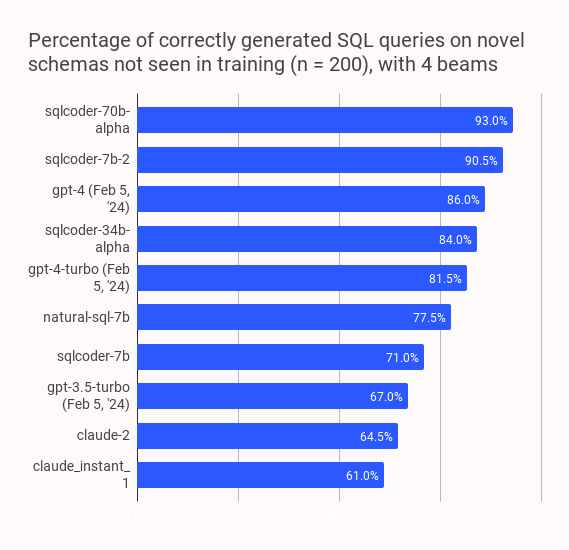